In [1917]:
# Run reviews_exploratiion.ipynb first.
import pandas as pd
import json
import ast
import numpy as np
import math
import missingno as msno
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from stargazer.stargazer import Stargazer
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.factorplots import interaction_plot

In [1918]:
# Import data.
games_returns_release_df = pd.read_csv('games_returns_release_date.csv')
games_returns_release_df.head()

,Unnamed: 0.1,name,mature,single_player,multiplayer,dist,hasLootBoxes,percentRecommended,numReviews,numTopCriticReviews,...,excess_return,NOKUSD,GBPUSD,JPYUSD,SEKUSD,PLNUSD,EURUSD,market_cap,mkt_cap_usd,volume_to_shares_outstanding
0,0,The Last Guardian,False,True,False,0.0,False,70.491803,128.0,96.0,...,-0.022378,0.119329,1.27050,0.008741,0.109188,0.238425,1.07250,3.991704e+12,3.489148e+10,0.005334
1,1,Empire of Sin,True,True,False,0.0,False,27.118644,60.0,40.0,...,0.037110,0.112910,1.33505,0.009590,0.116962,0.266809,1.19620,2.785728e+10,3.258243e+09,0.001424
2,4,One Punch Man: A Hero Nobody Knows,False,True,True,0.0,False,17.105263,76.0,52.0,...,0.037230,0.106388,1.28735,0.009092,0.103612,0.254278,1.09860,1.254300e+12,1.140410e+10,0.005621
3,6,Hatsune Miku: Project Diva Mega Mix,False,True,False,0.0,False,79.166667,48.0,30.0,...,0.008737,0.108018,1.30540,0.009106,0.103412,0.255057,1.08485,4.209088e+11,3.832796e+09,0.002410
4,7,Hatsune Miku: Project Diva Mega Mix,False,True,False,0.0,False,79.166667,48.0,30.0,...,0.008737,0.108018,1.30540,0.009106,0.103412,0.255057,1.08485,4.209088e+11,3.832796e+09,0.002410


In [1919]:
games_returns_release_df['hasLootBoxes'] = games_returns_release_df['hasLootBoxes'].astype(bool)

In [1920]:
# Check columns for columns that can be dropped.
games_returns_release_df.columns

Index(['Unnamed: 0.1', 'name', 'mature', 'single_player', 'multiplayer',
       'dist', 'hasLootBoxes', 'percentRecommended', 'numReviews',
       'numTopCriticReviews', 'medianScore', 'topCriticScore', 'percentile',
       'developer', 'publisher', 'stock_id', 'date', 'Unnamed: 0', 'gvkey',
       'iid', 'company_name', 'shares_outstanding', 'trading_volume',
       'closing_price', 'eu', 'jp', 'us', 'mkt-rf', 'smb', 'hml', 'rmw', 'cma',
       'rf', 'benchmark_price', 'returns', 'benchmark_returns',
       'excess_return', 'NOKUSD', 'GBPUSD', 'JPYUSD', 'SEKUSD', 'PLNUSD',
       'EURUSD', 'market_cap', 'mkt_cap_usd', 'volume_to_shares_outstanding'],
      dtype='object')

In [1921]:
games_returns_release_df.dtypes

Unnamed: 0.1                      int64
name                             object
mature                             bool
single_player                      bool
multiplayer                        bool
dist                            float64
hasLootBoxes                       bool
percentRecommended              float64
numReviews                      float64
numTopCriticReviews             float64
medianScore                     float64
topCriticScore                  float64
percentile                      float64
developer                          bool
publisher                          bool
stock_id                         object
date                             object
Unnamed: 0                      float64
gvkey                           float64
iid                              object
company_name                     object
shares_outstanding              float64
trading_volume                  float64
closing_price                   float64
eu                                 bool


In [1922]:
# Drop unused columns.
games_returns_release_df = games_returns_release_df.drop([
    'Unnamed: 0.1',
    'Unnamed: 0',
    'iid',
    'gvkey',
    'shares_outstanding',
    'market_cap',
    'benchmark_price',
    'closing_price',
    'trading_volume',
    'returns',
    'NOKUSD',
    'GBPUSD',
    'JPYUSD',
    'SEKUSD',
    'PLNUSD',
    'EURUSD',
    'benchmark_returns'
    ], axis=1)

games_returns_release_df.head()

,name,mature,single_player,multiplayer,dist,hasLootBoxes,percentRecommended,numReviews,numTopCriticReviews,medianScore,...,us,mkt-rf,smb,hml,rmw,cma,rf,excess_return,mkt_cap_usd,volume_to_shares_outstanding
0,The Last Guardian,False,True,False,0.0,False,70.491803,128.0,96.0,85.0,...,False,-0.99,0.35,0.03,0.11,0.19,0.00,-0.022378,3.489148e+10,0.005334
1,Empire of Sin,True,True,False,0.0,False,27.118644,60.0,40.0,62.5,...,False,-1.10,0.47,-1.31,0.02,-0.63,0.00,0.037110,3.258243e+09,0.001424
2,One Punch Man: A Hero Nobody Knows,False,True,True,0.0,False,17.105263,76.0,52.0,60.0,...,False,-1.63,-0.86,0.56,-0.49,0.33,0.01,0.037230,1.140410e+10,0.005621
3,Hatsune Miku: Project Diva Mega Mix,False,True,False,0.0,False,79.166667,48.0,30.0,80.0,...,False,-0.04,0.14,-0.56,0.34,-0.39,0.01,0.008737,3.832796e+09,0.002410
4,Hatsune Miku: Project Diva Mega Mix,False,True,False,0.0,False,79.166667,48.0,30.0,80.0,...,False,-0.04,0.14,-0.56,0.34,-0.39,0.01,0.008737,3.832796e+09,0.002410


In [1923]:
# Create log market cap.
games_returns_release_df['log_mkt_cap'] = np.log(games_returns_release_df['mkt_cap_usd'])

In [1924]:
games_returns_release_df[['mature',
                          'single_player', 
                          'multiplayer', 
                          'hasLootBoxes', 
                          'developer',
                          'publisher',
                          'eu',
                          'jp',
                          'us']] = games_returns_release_df[['mature',
                          'single_player', 
                          'multiplayer', 
                          'hasLootBoxes', 
                          'developer',
                          'publisher',
                          'eu',
                          'jp',
                          'us']].astype(int)

In [1925]:
# Calculate the number of unique games in the study.
games_returns_release_df['name'].unique().shape

(587,)

In [1926]:
games_returns_release_df['sizeMedianScore'] = games_returns_release_df['log_mkt_cap'] * games_returns_release_df['medianScore']
games_returns_release_df['turnoverMedianScore'] = games_returns_release_df['volume_to_shares_outstanding'] * games_returns_release_df['medianScore']
games_returns_release_df['sizeTopCriticScore'] = games_returns_release_df['log_mkt_cap'] * games_returns_release_df['topCriticScore']
games_returns_release_df['turnoverTopCriticScore'] = games_returns_release_df['volume_to_shares_outstanding'] * games_returns_release_df['topCriticScore']
games_returns_release_df['numMedianScore'] = games_returns_release_df['numTopCriticReviews'] * games_returns_release_df['topCriticScore']
games_returns_release_df['numTopCriticScore'] = games_returns_release_df['numReviews'] * games_returns_release_df['medianScore']

In [1927]:
# Drop duplicate observations.
duplicate = games_returns_release_df[games_returns_release_df.duplicated(['name', 'numReviews', 'medianScore', 'stock_id', 'dist', 'excess_return', 'hml', 'smb', 'date'])]
games_returns_release_df = games_returns_release_df.drop(duplicate.index)

In [1928]:
# Create de-meaned topCriticScore.
games_returns_release_df['de_mean_score'] = games_returns_release_df['topCriticScore'] - np.mean(games_returns_release_df['topCriticScore'])
games_returns_release_df['std_score'] = games_returns_release_df['de_mean_score'] / np.std(games_returns_release_df['topCriticScore'])
games_returns_release_df['log_excess_ret'] = np.log(games_returns_release_df['excess_return'] + 1)

<Axes: >

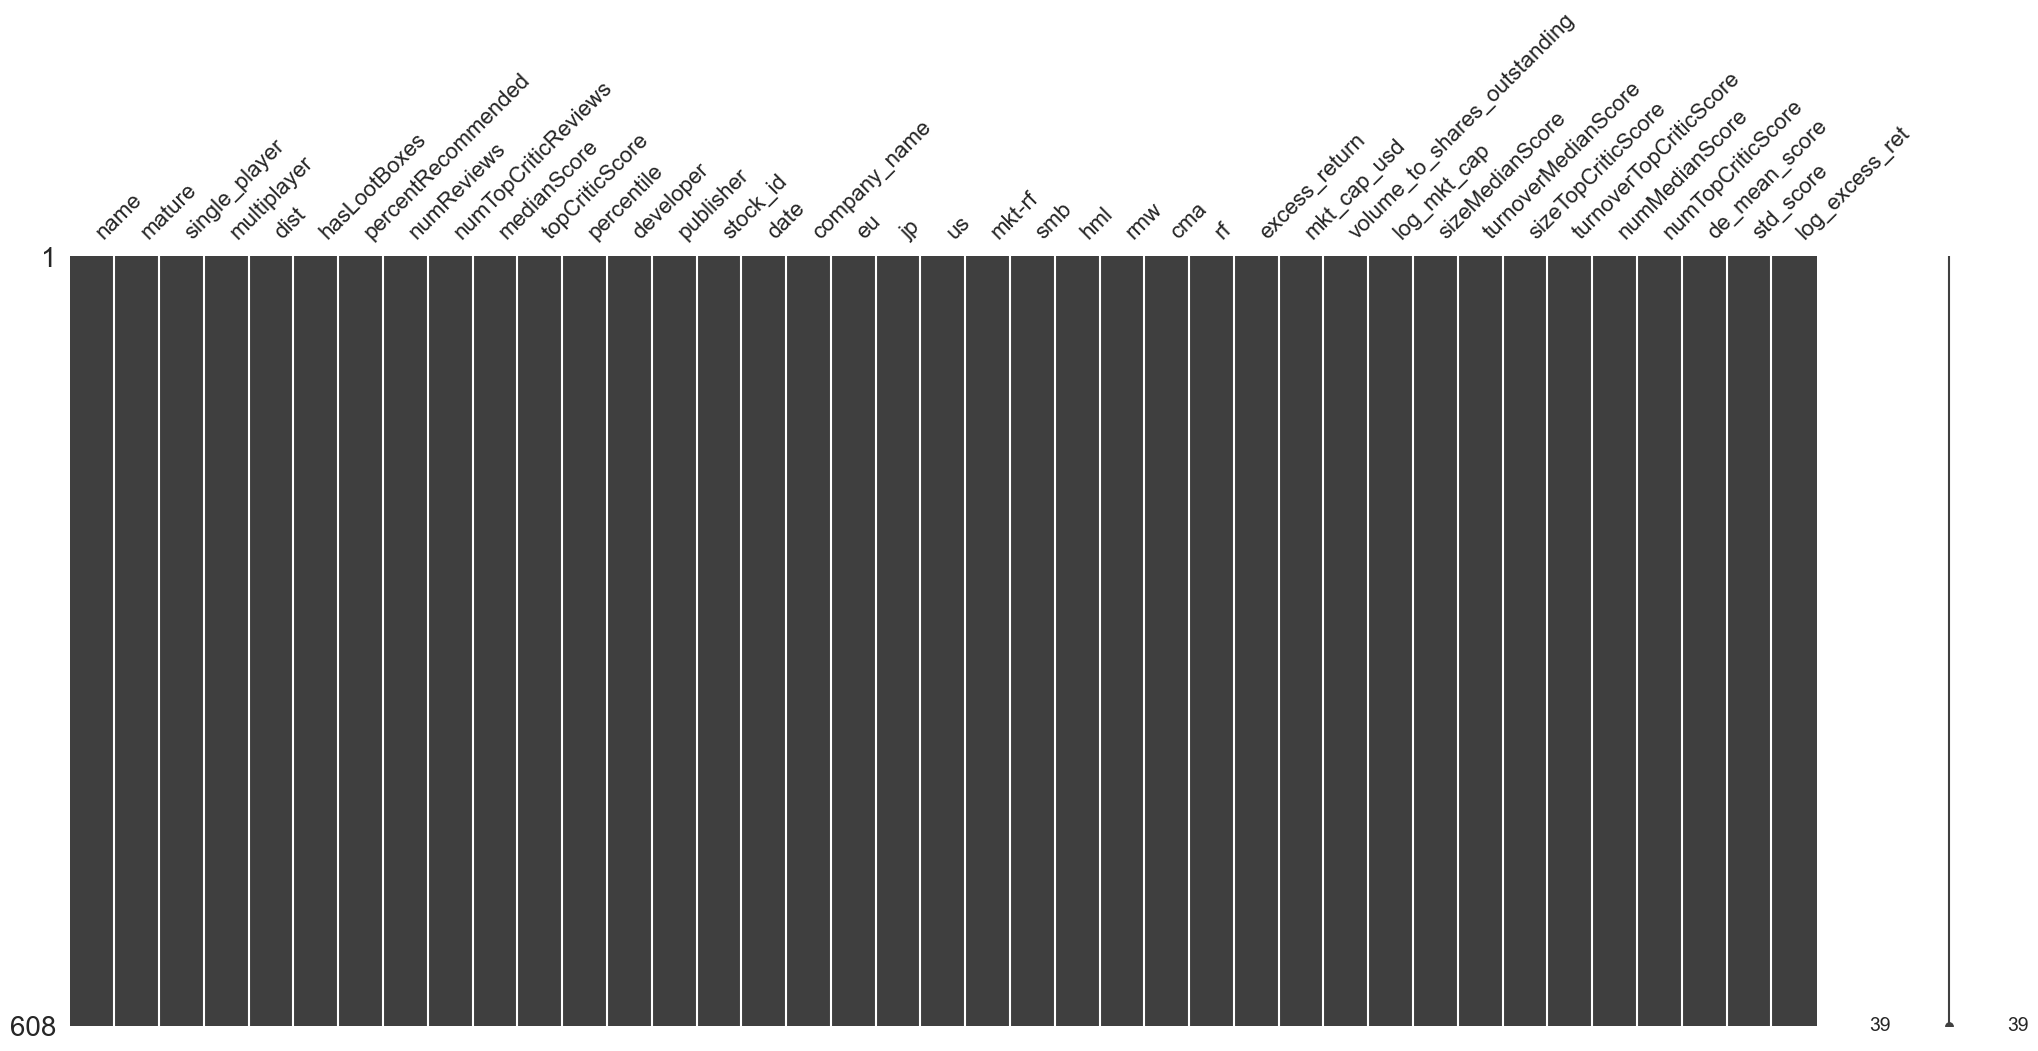

In [1929]:
# Plot missing data.
%matplotlib inline

msno.matrix(games_returns_release_df)

In [1930]:
def run_ols_model(df, dependent_var, independent_vars):
    X = df[independent_vars]
    Y = df[dependent_var]
    
    X = sm.add_constant(X)
    
    model = sm.OLS(Y, X).fit()
    predictions = model.predict(X)
    
    return model.summary()

In [1931]:
results_hic = run_ols_model(games_returns_release_df, 'log_excess_ret', ['mature',
                                                   'single_player', 
                                                   'multiplayer', 
                                                   #'hasLootBoxes', 
                                                   'developer',
                                                   'publisher',
                                                   'eu',
                                                   'jp',
                                                   'us',
                                                   'mkt-rf',
                                                   'smb',
                                                   'hml',
                                                   'rmw',
                                                   'cma',
                                                   'rf',
                                                   'log_mkt_cap',
                                                   'de_mean_score',
                                                   'std_score'])
print(results_hic)

                            OLS Regression Results                            
Dep. Variable:         log_excess_ret   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.096
Date:                Mon, 26 Jun 2023   Prob (F-statistic):              0.358
Time:                        15:11:09   Log-Likelihood:                 1143.2
No. Observations:                 608   AIC:                            -2256.
Df Residuals:                     593   BIC:                            -2190.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0017      0.012     -0.138

In [1932]:
def subplot_common_y(df, dependent_var, independent_vars, num_columns, y_label, **kwargs):

    titles = kwargs.get('titles', None)
    x_labels = kwargs.get('x_labels', None)
    y = df[dependent_var]
    suptitle = kwargs.get('suptitle', None)
    colours=kwargs.get('colours')
    figure_size = kwargs.get('figure_size', None)
    image_name = kwargs.get('image_name', None)

    if not image_name:
        image_name = 'test.png'

    # Calculate the number of subplots based on how many X values being compared.
    num_subplots = len(independent_vars)

    if not figure_size:
        figure_size = (9,9)

    rows = math.ceil(num_subplots/num_columns)
    cols = num_columns
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize = figure_size)
    fig.suptitle(suptitle)

    for i, ax in enumerate(fig.axes):
        try:
            x = df[independent_vars[i]]
            ax.scatter(x, y, s=20, alpha=0.1, edgecolors="k", c='gray')
            if titles != None:
                ax.set_title(titles[i])
            if x_labels != None:
                ax.set_xlabel(x_labels[i])
            if i == 0 or i == 3:
                ax.set_ylabel(y_label)
            b, a = np.polyfit(x, y, deg=1)

            # Create sequence of 100 numbers from 0 to 100 
            xseq = np.linspace(0, max(x), num=100)

            # Plot regression line
            ax.plot(xseq, a + b * xseq, color="r", lw=1)

        except KeyError:
            print('Too many indices.')
            continue
    fig.savefig(image_name)


In [1933]:
# Financial variables descriptive stats.
games_returns_release_df[[
    'log_mkt_cap',
    'mkt-rf',
    'smb',
    'hml',
    'rmw',
    'cma',
    'log_excess_ret',
    'volume_to_shares_outstanding']].describe().style.format({'D':'{:0.5f}'},precision=5)#.to_latex('companies_descriptive_stats.tex')

,log_mkt_cap,mkt-rf,smb,hml,rmw,cma,log_excess_ret,volume_to_shares_outstanding
count,608.00000,608.00000,608.00000,608.00000,608.00000,608.00000,608.00000,608.00000
mean,21.90925,-0.02870,0.00021,0.05138,-0.00062,0.02013,0.00209,0.00629
std,2.60895,1.19175,0.45904,0.79108,0.38997,0.41430,0.03742,0.00890
min,15.11885,-7.82000,-1.83000,-3.10000,-1.72000,-1.30000,-0.35960,0.00000
25%,19.90124,-0.57000,-0.27000,-0.39250,-0.19250,-0.20000,-0.01402,0.00221
50%,22.15310,0.01500,0.00000,0.03500,0.02000,0.00000,0.00074,0.00389
75%,23.83232,0.58250,0.28000,0.48000,0.23000,0.23000,0.01749,0.00674
max,28.55765,9.53000,2.21000,4.57000,1.42000,2.30000,0.24572,0.11501


In [1934]:
games_returns_release_df.describe()[[
    'dist',
    'percentRecommended',
    'numReviews',
    'numTopCriticReviews',
    'medianScore',
    'topCriticScore',
    'percentile'
    ]].style.format({'D':'{:0.5f}'},precision=5)#.to_latex('games_descriptive_stats.tex')

,dist,percentRecommended,numReviews,numTopCriticReviews,medianScore,topCriticScore,percentile
count,608.00000,608.00000,608.00000,608.00000,608.00000,608.00000,608.00000
mean,0.00000,53.47980,67.00000,47.30757,73.94572,72.35681,55.23684
std,0.00000,28.29096,48.43382,34.84500,11.22246,10.94603,28.38073
min,0.00000,0.00000,5.00000,3.00000,20.00000,26.00000,0.00000
25%,0.00000,30.44085,27.00000,18.00000,70.00000,66.92067,31.00000
50%,0.00000,54.47273,55.00000,39.00000,75.00000,73.46985,56.00000
75%,0.00000,77.77778,101.25000,72.25000,80.00000,80.00568,81.50000
max,0.00000,100.00000,251.00000,189.00000,100.00000,96.81081,100.00000


In [1935]:
# Count how many games.
games_returns_release_df['name'].nunique()

587

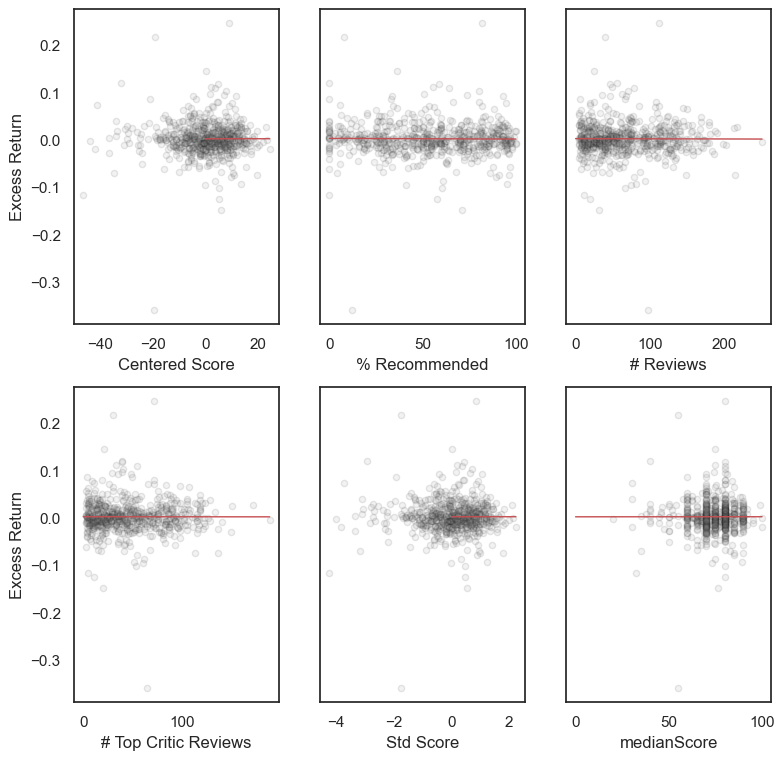

In [1936]:
subplot_common_y(
    df=games_returns_release_df,#[games_returns_release_df['numTopCriticReviews'] > 39],
    dependent_var='log_excess_ret',
    independent_vars=[
        'de_mean_score',
        'percentRecommended',
        'numReviews',
        'numTopCriticReviews',
        'std_score',
        'medianScore'
        ],
    num_columns=3,
    x_labels =[
        'Centered Score',
        '% Recommended',
        '# Reviews',
        '# Top Critic Reviews',
        'Std Score',
        'medianScore'
        ],
    y_label='Excess Return'
  )

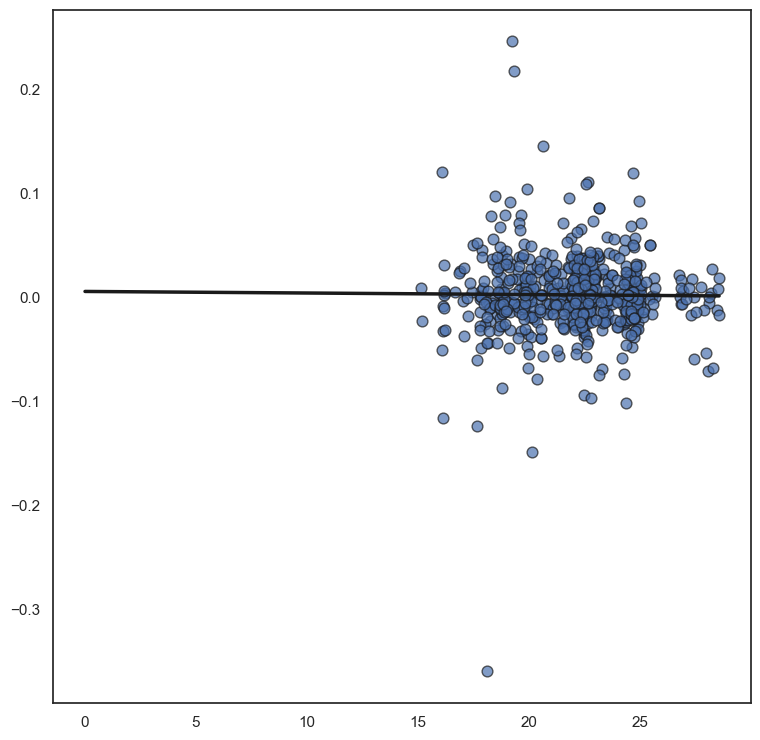

In [1937]:
# Generate data
data_df = games_returns_release_df#[(games_returns_release_df['excess_return'] < 3.5) & (games_returns_release_df['numTopCriticReviews'] > 40)]
x = data_df['log_mkt_cap']
y = np.log(data_df['excess_return'] + 1)

# Initialize layout
fig, ax = plt.subplots(figsize = (9, 9))

# Add scatterplot
ax.scatter(x, y, s=60, alpha=0.7, edgecolors="k")

# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
# deg=1 means linear fit (i.e. polynomial of degree 1)
b, a = np.polyfit(x, y, deg=1)

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(0, max(x), num=100)

# Plot regression line
ax.plot(xseq, a + b * xseq, color="k", lw=2.5)

In [1938]:
corr_matrix = games_returns_release_df[['mature',
                          'single_player', 
                          'multiplayer', 
                          'hasLootBoxes', 
                          'medianScore',
                          'percentRecommended',
                          'numReviews',
                          'numTopCriticReviews',
                          'topCriticScore',
                          'percentile',
                          'developer',
                          'publisher',
                          'eu',
                          'jp',
                          'us',
                          'mkt-rf',
                          'smb',
                          'hml',
                          'rmw',
                          'cma',
                          'rf',
                          'log_mkt_cap',
                          'volume_to_shares_outstanding',
                          'log_excess_ret']][games_returns_release_df['excess_return'] < 3].corr()

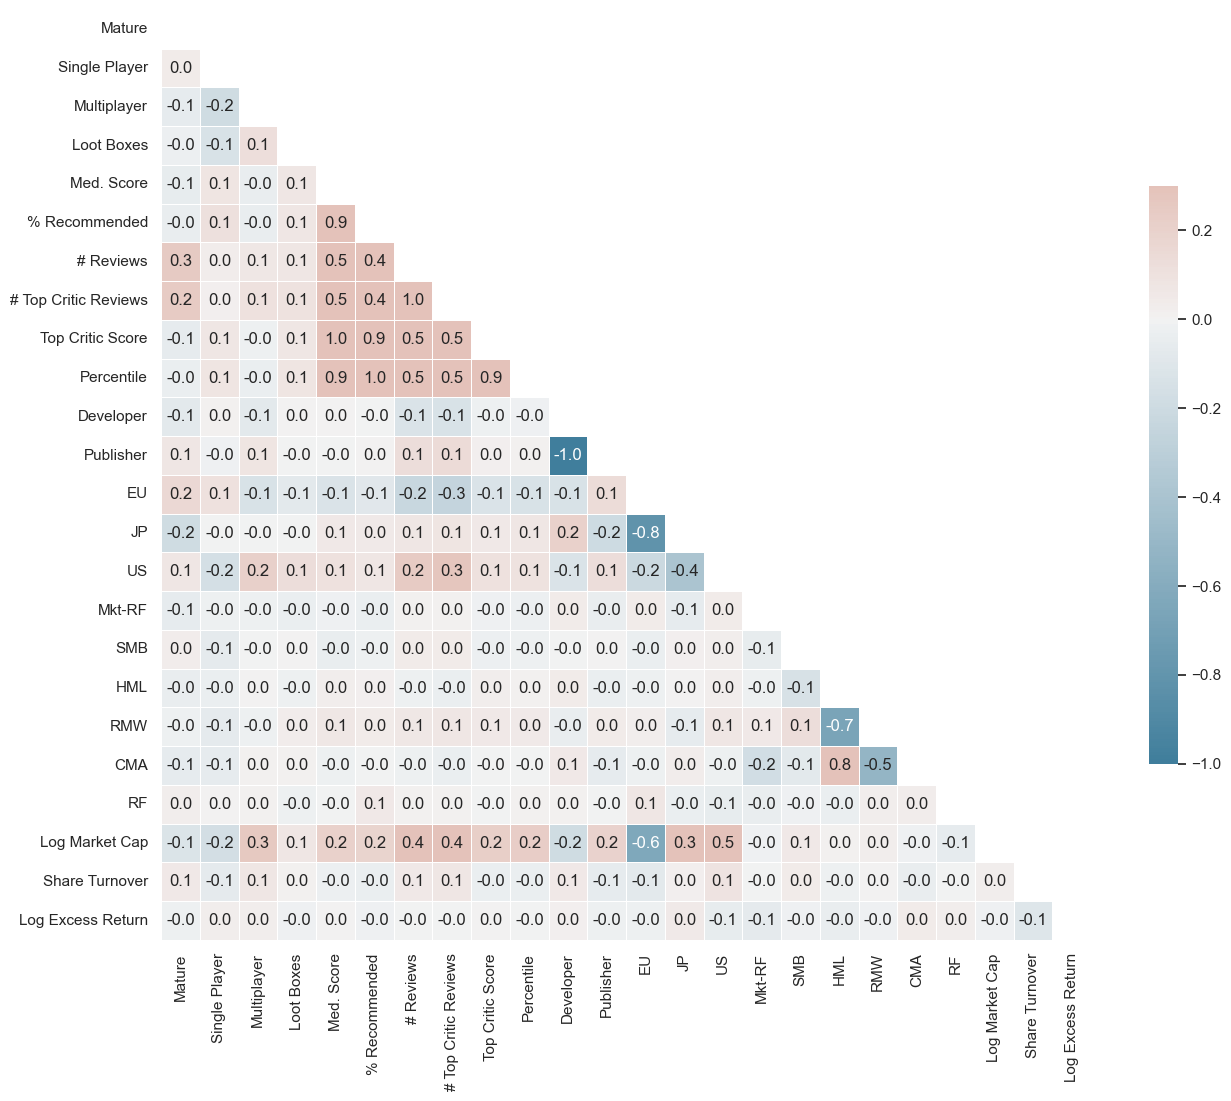

In [1939]:
sns.set_theme(style="white")

label = [
        'Mature',
        'Single Player',
        'Multiplayer',
        'Loot Boxes',
        'Med. Score',
        '% Recommended',
        '# Reviews',
        '# Top Critic Reviews',
        'Top Critic Score',
        'Percentile',
        'Developer',
        'Publisher',
        'EU',
        'JP',
        'US',
        'Mkt-RF',
        'SMB',
        'HML',
        'RMW',
        'CMA',
        'RF',
        'Log Market Cap',
        'Share Turnover',
        'Log Excess Return',
        ]
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap=cmap,
    vmax=.3,
    center=0,
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .5},
    xticklabels=label,
    yticklabels=label,
    annot=True,
    fmt=".1f"
      )
f.savefig('correlation_matrix_heatmap.png')

In [1940]:
def subplot_hist(df, variables, num_columns, x_labels, share_y_axis, image_name, **kwargs):

    titles = kwargs.get('titles', None)
    suptitle = kwargs.get('suptitle', None)
    num_bins = kwargs.get('bins', None)
    figure_size = kwargs.get('figure_size', None)
    y_label_plots = kwargs.get('y_label_plots', None)
    special = kwargs.get('special', None)

    if not figure_size:
        figure_size = (9,9)

    # Calculate the number of subplots based on how many X values being compared.
    num_subplots = len(variables)

    # Calculate how many rows there should be per column.
    rows = math.ceil(num_subplots/num_columns)
    # Number of columns provided as an input.
    cols = num_columns
    fig, axs = plt.subplots(rows, cols, sharey=share_y_axis, figsize = figure_size)
    if rows*cols> num_subplots:
        fig.delaxes(axs.flatten()[-1])
    if suptitle:
        fig.suptitle(suptitle)

    for i, ax in enumerate(axs.flat):

        if special:
            if i == special[0] and special[1]:
                num_bins = special[2]
            else:
                num_bins = num_bins = kwargs.get('bins', None)
        try:
            if i > num_subplots -1 :
                continue
            bin_size = (max(df[variables[i]]) - min(df[variables[i]]))/num_bins
            y = df[variables[i]]
            sns.histplot(
                y,
                kde=True,
                ax=ax,
                binwidth=bin_size,
                edgecolor='black',
                color='gray')
            if titles != None:
                ax.set_title(titles[i])
            if x_labels != None:
                ax.set_xlabel(x_labels[i])
            if y_label_plots:
                if i in y_label_plots:
                    ax.set_ylabel('Count')
                else:
                    ax.set_ylabel('')

        except KeyError:
            print('Too many indices.')
            continue
    fig.savefig(image_name) 

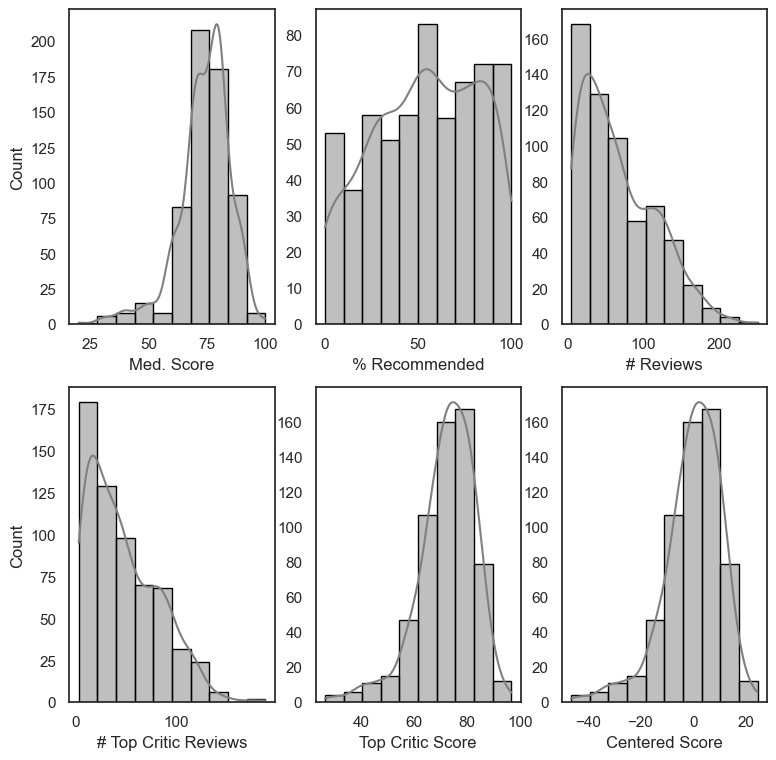

In [1941]:
# Plot histograms of review metrics.
subplot_hist(
    df=games_returns_release_df,
    variables=[
        'medianScore',
        'percentRecommended',
        'numReviews',
        'numTopCriticReviews',
        'topCriticScore',
        'de_mean_score'
        ],
    num_columns=3,
    x_labels=[
        'Med. Score',
        '% Recommended',
        '# Reviews',
        '# Top Critic Reviews',
        'Top Critic Score',
        'Centered Score'
        ],
    share_y_axis=False,
    bins=10,
    image_name='review_metrics_distributions.png',
    y_label_plots=[0,3]
    )

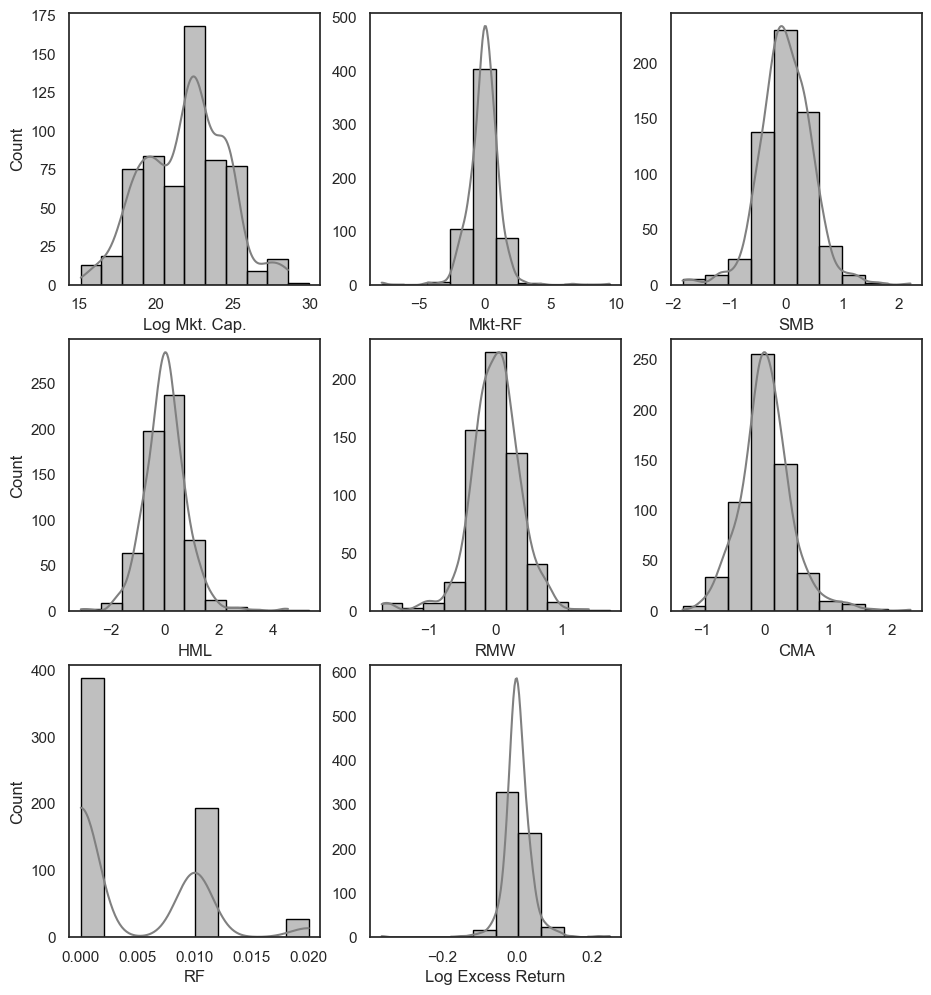

In [1942]:
# Plot histograms of financial data.
subplot_hist(
    df=games_returns_release_df,
    variables=[
        'log_mkt_cap',
        'mkt-rf',
        'smb',
        'hml',
        'rmw',
        'cma',
        'rf',
        'log_excess_ret'
        ],
    num_columns=3,
    x_labels=[
        'Log Mkt. Cap.',
        'Mkt-RF',
        'SMB',
        'HML',
        'RMW',
        'CMA',
        'RF',
        'Log Excess Return'
        ],
    share_y_axis=False,
    bins=10,
    image_name='financial_metrics_distributions.png',
    figure_size = (11,12),
    y_label_plots=[0,3,6]
    )

In [1943]:
games_returns_release_df.columns

Index(['name', 'mature', 'single_player', 'multiplayer', 'dist',
       'hasLootBoxes', 'percentRecommended', 'numReviews',
       'numTopCriticReviews', 'medianScore', 'topCriticScore', 'percentile',
       'developer', 'publisher', 'stock_id', 'date', 'company_name', 'eu',
       'jp', 'us', 'mkt-rf', 'smb', 'hml', 'rmw', 'cma', 'rf', 'excess_return',
       'mkt_cap_usd', 'volume_to_shares_outstanding', 'log_mkt_cap',
       'sizeMedianScore', 'turnoverMedianScore', 'sizeTopCriticScore',
       'turnoverTopCriticScore', 'numMedianScore', 'numTopCriticScore',
       'de_mean_score', 'std_score', 'log_excess_ret'],
      dtype='object')

In [1944]:
def subplot_bar(df, variables, num_columns, x_labels, legend_labels, **kwargs):

    titles = kwargs.get('titles', None)
    suptitle = kwargs.get('suptitle', None)
    colours = kwargs.get('colours', None)
    bar_labels = kwargs.get('bar_labels', None)
    figure_size = kwargs.get('figure_size', None)
    y_label_plots = kwargs.get('y_label_plots', None)

    if not figure_size:
        figure_size = (9,9)

    # Calculate the number of subplots based on how many X values being compared.
    num_subplots = len(variables)

    rows = math.ceil(num_subplots/num_columns)
    cols = num_columns
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize = figure_size)
    if rows*cols> num_subplots:
        fig.delaxes(axs.flatten()[-1])

    if suptitle != None:
        fig.suptitle(suptitle)

    for i, ax in enumerate(fig.axes):
        try:
            y = df[variables[i]]
            if colours != None:
                p = ax.bar(
                    bar_labels[i],
                    y.value_counts(),
                    label=legend_labels[i],
                    colors=colours[i]
                )
                ax.bar_label(p, label_type='center')
            else:
                p = ax.bar(
                    bar_labels[i],
                    y.value_counts(),
                    label=legend_labels[i],
                    color=(0.1, 0.1, 0.1, 0.1),
                    edgecolor='k'
                )
                ax.bar_label(p, label_type='center')
            if titles != None:
                ax.set_title(titles[i])
            if x_labels != None:
                ax.set_xlabel(x_labels[i])
            if y_label_plots:
                if i in y_label_plots:
                    ax.set_ylabel('Count')
                else:
                    ax.set_ylabel('')

        except KeyError:
            print('Too many indices.')
            continue

    fig.savefig('games_categorical_barchart.png') 

In [1945]:
def add_region_name(eu_bool, jp_bool, us_bool):
    if eu_bool:
        return 'eu'
    elif jp_bool:
        return 'jp'
    else:
        return 'us'

In [1946]:
def add_dev_pub(dev_bool, pub_bool):
    if dev_bool:
        return 'developer'
    elif pub_bool:
        return 'publisher'
    else:
        return 'neither'

In [1947]:
def add_mature(mature_bool):
    if mature_bool:
        return 'mature'
    elif not mature_bool:
        return 'other'
    else:
        return 'neither'

In [1948]:
def add_multiplayer(multi_bool):
    if multi_bool:
        return 'Multiplayer'
    else:
        return 'Single Player'

In [1949]:
games_returns_release_df['region'] = games_returns_release_df.apply(lambda x: add_region_name(eu_bool=x['eu'], jp_bool=x['jp'], us_bool=x['us']), axis=1)
games_returns_release_df['dev_pub'] = games_returns_release_df.apply(lambda x: add_dev_pub(dev_bool=x['developer'], pub_bool=x['publisher']), axis=1)
games_returns_release_df['age_rating'] = games_returns_release_df['mature'].map(add_mature)
games_returns_release_df['players'] = games_returns_release_df['multiplayer'].map(add_multiplayer)

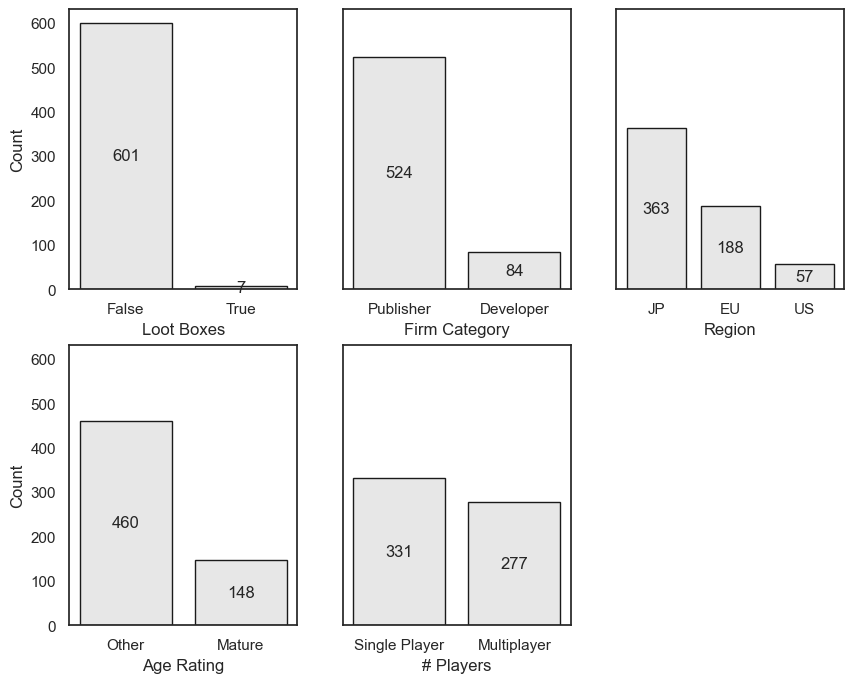

In [1950]:
subplot_bar(
    df=games_returns_release_df,
    variables=[
        'hasLootBoxes',
        'dev_pub',
        'region',
        'age_rating',
        'players'
    ],
    num_columns=3,
    x_labels=[
        'Loot Boxes',
        'Firm Category',
        'Region',
        'Age Rating',
        '# Players'
    ],
    legend_labels=[
        'Loot Boxes',
        'Firm Category',
        'Region',
        'Age Rating',
        '# Players'
    ],
    bar_labels=[
        ['False', 'True'],
        ['Publisher', 'Developer'],
        ['JP', 'EU', 'US'],
        ['Other', 'Mature'],
        ['Single Player', 'Multiplayer']
    ],
    figure_size=(10,8),
    y_label_plots=[0,3]
    )

In [1951]:
games_returns_release_df[(games_returns_release_df['single_player'] == True) & (games_returns_release_df['multiplayer'] == True)]

,name,mature,single_player,multiplayer,dist,hasLootBoxes,percentRecommended,numReviews,numTopCriticReviews,medianScore,...,turnoverTopCriticScore,numMedianScore,numTopCriticScore,de_mean_score,std_score,log_excess_ret,region,dev_pub,age_rating,players
2,One Punch Man: A Hero Nobody Knows,0,1,1,0.0,0,17.105263,76.0,52.0,60.0,...,0.329114,3044.549020,4560.0,-13.807795,-1.262481,0.036554,jp,publisher,other,Multiplayer
5,One Piece: Pirate Warriors 4,0,1,1,0.0,0,65.789474,76.0,57.0,75.0,...,0.168206,4267.875000,5700.0,2.518185,0.230244,0.013407,jp,developer,other,Multiplayer
6,One Piece: Pirate Warriors 4,0,1,1,0.0,0,65.789474,76.0,57.0,75.0,...,0.400649,4267.875000,5700.0,2.518185,0.230244,0.039110,jp,publisher,other,Multiplayer
10,Zumba: Burn it Up!,0,1,1,0.0,0,60.000000,5.0,5.0,70.0,...,1.743735,345.000000,350.0,-3.356815,-0.306922,0.031952,eu,publisher,other,Multiplayer
14,Humankind,0,1,1,0.0,0,61.538462,53.0,39.0,80.0,...,0.256466,3099.972973,4240.0,7.129672,0.651884,-0.006535,jp,publisher,other,Multiplayer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713,Dragon Quest Heroes II,0,1,1,0.0,0,62.500000,72.0,63.0,80.0,...,0.890020,4926.000000,5760.0,5.833662,0.533386,-0.002962,jp,publisher,other,Multiplayer
714,Pokémon Scarlet,0,1,1,0.0,0,47.154472,127.0,87.0,70.0,...,0.341416,6210.588608,8890.0,-0.970739,-0.088757,-0.019945,jp,publisher,other,Multiplayer
716,Pokémon Violet,0,1,1,0.0,0,47.154472,127.0,87.0,70.0,...,0.341416,6210.588608,8890.0,-0.970739,-0.088757,-0.019945,jp,publisher,other,Multiplayer
718,Dr Kawashima's Brain Training for Nintendo Switch,0,1,1,0.0,0,29.411765,22.0,19.0,70.0,...,0.322411,1264.230769,1540.0,-5.818353,-0.531987,0.050056,jp,publisher,other,Multiplayer


In [1952]:
columns = [
    'mature',                      # 0
    'single_player',               # 1
    'multiplayer',                 # 2
    'hasLootBoxes',                # 3
    'medianScore',                 # 4
    'percentRecommended',          # 5
    'numReviews',                  # 6
    'numTopCriticReviews',         # 7
    'topCriticScore',              # 8
    'percentile',                  # 9
    'developer',                   # 10
    'publisher',                   # 11
    'eu',                          # 12
    'jp',                          # 13
    'us',                          # 14
    'mkt-rf',                      # 15
    'smb',                         # 16
    'hml',                         # 17
    'rmw',                         # 18
    'cma',                         # 19
    'rf',                          # 20
    'mkt_cap_usd',                 # 21
    'volume_to_shares_outstanding', # 22
    'sizeMedianScore',              # 23
    'turnoverMedianScore',          # 24
    'sizeTopCriticScore',           # 25
    'turnoverTopCriticScore',       # 26
    'numMedianScore',               # 27
    'numTopCriticScore'             # 28
  ]

In [1953]:
games_returns_release_df[games_returns_release_df['excess_return'] > 3]

,name,mature,single_player,multiplayer,dist,hasLootBoxes,percentRecommended,numReviews,numTopCriticReviews,medianScore,...,turnoverTopCriticScore,numMedianScore,numTopCriticScore,de_mean_score,std_score,log_excess_ret,region,dev_pub,age_rating,players


Create a log return column for running the regressions.

In [1954]:
games_returns_release_df['log_excess_ret'] = np.log(games_returns_release_df['excess_return'] + 1)

In [1955]:
games_returns_release_df.dtypes

name                             object
mature                            int64
single_player                     int64
multiplayer                       int64
dist                            float64
hasLootBoxes                      int64
percentRecommended              float64
numReviews                      float64
numTopCriticReviews             float64
medianScore                     float64
topCriticScore                  float64
percentile                      float64
developer                         int64
publisher                         int64
stock_id                         object
date                             object
company_name                     object
eu                                int64
jp                                int64
us                                int64
mkt-rf                          float64
smb                             float64
hml                             float64
rmw                             float64
cma                             float64


# Univariate Regression

In [1956]:
# df = games_returns_release_df[games_returns_release_df['excess_return'] < 3]
df = games_returns_release_df

mature = sm.OLS(endog=df['log_excess_ret'], exog=sm.add_constant(df['mature'])).fit(cov_type='HC3')
mature = sm.OLS(endog=df['log_excess_ret'], exog=sm.add_constant(df['mature'])).fit(cov_type='HC3')
singlePlayer = sm.OLS(endog=df['log_excess_ret'], exog=sm.add_constant(df['single_player'])).fit(cov_type='HC3')
lootBoxes = sm.OLS(endog=df['log_excess_ret'], exog=sm.add_constant(df['hasLootBoxes'])).fit(cov_type='HC3')
publisher = publisher = sm.OLS(endog=df['log_excess_ret'], exog=sm.add_constant(df['publisher'])).fit(cov_type='HC3')
japan = sm.OLS(endog=df['log_excess_ret'], exog=sm.add_constant(df['jp'])).fit(cov_type='HC3')
Score = sm.OLS(endog=df['log_excess_ret'], exog=sm.add_constant(df['topCriticScore'])).fit(cov_type='HC3')
numTopCriticReviews = sm.OLS(endog=df['log_excess_ret'], exog=sm.add_constant(df['numTopCriticReviews'])).fit(cov_type='HC3')
combined = sm.OLS(endog=df['log_excess_ret'], exog=sm.add_constant(df[[
    'mature',
    'single_player',
    'hasLootBoxes',
    'publisher',
    'jp',
    'topCriticScore'
    ]])).fit(cov_type='HC3')


stargazer = Stargazer([
    mature,
    singlePlayer,
    lootBoxes,
    publisher,
    japan,
    Score,
    numTopCriticReviews,
    combined
    ]
)

stargazer.covariate_order([
    'mature',
    'single_player',
    'hasLootBoxes',
    'publisher',
    'jp',
    'topCriticScore',
    'numTopCriticReviews',
    'const'
  ])

stargazer.rename_covariates({
    'mature': 'Mature',
    'single_player':'Single Player',
    'hasLootBoxes': 'Loot Boxes',
    'medianScore': 'Score',
    'numTopCriticReviews': '\# Top Critic Reviews',
    'topCriticScore': 'Top Critic Score',
    'publisher': 'Publisher',
    'jp': 'Japan',
    'const': 'Const.'
    }
  )

stargazer.significant_digits(5)

print(stargazer.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lcccccccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{8}{c}{\textit{Dependent variable:}} \
\cr \cline{8-9}
\\[-1.8ex] & (1) & (2) & (3) & (4) & (5) & (6) & (7) & (8) \\
\hline \\[-1.8ex]
 Mature & -0.00172$^{}$ & & & & & & & -0.00110$^{}$ \\
  & (0.00453) & & & & & & & (0.00431) \\
 Single Player & & 0.00488$^{}$ & & & & & & 0.00480$^{}$ \\
  & & (0.00631) & & & & & & (0.00638) \\
 Loot Boxes & & & -0.00434$^{}$ & & & & & -0.00308$^{}$ \\
  & & & (0.00694) & & & & & (0.00711) \\
 Publisher & & & & -0.00177$^{}$ & & & & -0.00070$^{}$ \\
  & & & & (0.00625) & & & & (0.00670) \\
 Japan & & & & & 0.00353$^{}$ & & & 0.00326$^{}$ \\
  & & & & & (0.00333) & & & (0.00330) \\
 Top Critic Score & & & & & & 0.00000$^{}$ & & -0.00001$^{}$ \\
  & & & & & & (0.00018) & & (0.00018) \\
 \# Top Critic Reviews & & & & & & & -0.00000$^{}$ & \\
  & & & & & & & (0.00004) & \\
 Const. & 0.00250$^{*}$ & -0.00259$^{}$ & 0.00214$^{}$ &

Create interaction variables between proposed metrics and size.

In [1957]:
# df = games_returns_release_df[games_returns_release_df['excess_return'] < 3]
df = games_returns_release_df

mature = sm.OLS(endog=df['volume_to_shares_outstanding'], exog=sm.add_constant(df['mature'])).fit(cov_type='HC3')
mature = sm.OLS(endog=df['volume_to_shares_outstanding'], exog=sm.add_constant(df['mature'])).fit(cov_type='HC3')
singlePlayer = sm.OLS(endog=df['volume_to_shares_outstanding'], exog=sm.add_constant(df['single_player'])).fit(cov_type='HC3')
lootBoxes = sm.OLS(endog=df['volume_to_shares_outstanding'], exog=sm.add_constant(df['hasLootBoxes'])).fit(cov_type='HC3')
publisher = publisher = sm.OLS(endog=df['volume_to_shares_outstanding'], exog=sm.add_constant(df['publisher'])).fit(cov_type='HC3')
japan = sm.OLS(endog=df['volume_to_shares_outstanding'], exog=sm.add_constant(df['jp'])).fit(cov_type='HC3')
Score = sm.OLS(endog=df['volume_to_shares_outstanding'], exog=sm.add_constant(df['topCriticScore'])).fit(cov_type='HC3')
numTopCriticReviews = sm.OLS(endog=df['volume_to_shares_outstanding'], exog=sm.add_constant(df['numTopCriticReviews'])).fit(cov_type='HC3')
combined = sm.OLS(endog=df['volume_to_shares_outstanding'], exog=sm.add_constant(df[[
    'mature',
    'single_player',
    'hasLootBoxes',
    'publisher',
    'jp',
    'topCriticScore'
    ]])).fit(cov_type='HC3')


stargazer = Stargazer([
    mature,
    singlePlayer,
    lootBoxes,
    publisher,
    japan,
    Score,
    numTopCriticReviews,
    combined
    ]
)

stargazer.covariate_order([
    'mature',
    'single_player',
    'hasLootBoxes',
    'publisher',
    'jp',
    'topCriticScore',
    'numTopCriticReviews',
    'const'
  ])

stargazer.rename_covariates({
    'mature': 'Mature',
    'single_player':'Single Player',
    'hasLootBoxes': 'Loot Boxes',
    'medianScore': 'Score',
    'numTopCriticReviews': '\# Top Critic Reviews',
    'topCriticScore': 'Top Critic Score',
    'publisher': 'Publisher',
    'jp': 'Japan',
    'const': 'Const.'
    }
  )

stargazer.significant_digits(5)

print(stargazer.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lcccccccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{8}{c}{\textit{Dependent variable:}} \
\cr \cline{8-9}
\\[-1.8ex] & (1) & (2) & (3) & (4) & (5) & (6) & (7) & (8) \\
\hline \\[-1.8ex]
 Mature & 0.00120$^{}$ & & & & & & & 0.00140$^{}$ \\
  & (0.00114) & & & & & & & (0.00105) \\
 Single Player & & -0.00308$^{*}$ & & & & & & -0.00313$^{*}$ \\
  & & (0.00187) & & & & & & (0.00189) \\
 Loot Boxes & & & 0.00090$^{}$ & & & & & 0.00041$^{}$ \\
  & & & (0.00238) & & & & & (0.00222) \\
 Publisher & & & & -0.00151$^{}$ & & & & -0.00155$^{}$ \\
  & & & & (0.00169) & & & & (0.00183) \\
 Japan & & & & & 0.00031$^{}$ & & & 0.00035$^{}$ \\
  & & & & & (0.00081) & & & (0.00080) \\
 Top Critic Score & & & & & & -0.00003$^{}$ & & -0.00002$^{}$ \\
  & & & & & & (0.00004) & & (0.00004) \\
 \# Top Critic Reviews & & & & & & & 0.00002$^{*}$ & \\
  & & & & & & & (0.00001) & \\
 Const. & 0.00600$^{***}$ & 0.00924$^{***}$ & 0.00628$^

In [1958]:
games_returns_release_df['LogsizeTopCriticScore'] = games_returns_release_df['log_mkt_cap'] * games_returns_release_df['topCriticScore']
games_returns_release_df['numTopCriticScore'] = games_returns_release_df['numTopCriticReviews'] * games_returns_release_df['topCriticScore']


In [1959]:
df = games_returns_release_df

LogsizeTopCriticScore = sm.OLS(endog=df['log_excess_ret'], exog=sm.add_constant(df[[
    'LogsizeTopCriticScore',
    'topCriticScore',
    'log_mkt_cap'
    ]])).fit(cov_type='HC3')
numTopCriticScore = sm.OLS(endog=df['log_excess_ret'], exog=sm.add_constant(df[[
    'numTopCriticScore',
    'topCriticScore',
    'numTopCriticReviews'
    ]])).fit(cov_type='HC3')

stargazer = Stargazer([
    LogsizeTopCriticScore,
    numTopCriticScore
    ]
)

stargazer.covariate_order([
    'topCriticScore',
    'log_mkt_cap',
    'LogsizeTopCriticScore',
    'numTopCriticReviews',
    'numTopCriticScore',
    'const'
    ]
  )

stargazer.rename_covariates({
    'LogsizeTopCriticScore': 'Size x Top Critic Score',
    'numTopCriticScore': '\# Top Critic Reviews x Top Critic Score',
    'numTopCriticReviews': '\# Top Critic Reviews',
    'topCriticScore': 'Score',
    'log_mkt_cap': 'Size',
    'const': 'Const.'
    }
  )
stargazer.significant_digits(5)

print(stargazer.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lcc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{2}{c}{\textit{Dependent variable:}} \
\cr \cline{2-3}
\\[-1.8ex] & (1) & (2) \\
\hline \\[-1.8ex]
 Score & 0.00226$^{}$ & -0.00001$^{}$ \\
  & (0.00206) & (0.00027) \\
 Size & 0.00723$^{}$ & \\
  & (0.00660) & \\
 Size x Top Critic Score & -0.00010$^{}$ & \\
  & (0.00009) & \\
 \# Top Critic Reviews & & -0.00003$^{}$ \\
  & & (0.00042) \\
 \# Top Critic Reviews x Top Critic Score & & 0.00000$^{}$ \\
  & & (0.00001) \\
 Const. & -0.15652$^{}$ & 0.00278$^{}$ \\
  & (0.15309) & (0.01951) \\
\hline \\[-1.8ex]
 Observations & 608 & 608 \\
 $R^2$ & 0.00728 & 0.00001 \\
 Adjusted $R^2$ & 0.00235 & -0.00495 \\
 Residual Std. Error & 0.03737(df = 604) & 0.03751(df = 604)  \\
 F Statistic & 0.94316$^{}$ (df = 3.0; 604.0) & 0.00150$^{}$ (df = 3.0; 604.0) \\
\hline
\hline \\[-1.8ex]
\textit{Note:} & \multicolumn{2}{r}{$^{*}$p$<$0.1; $^{**}$p$<$0.05; $^{***}$p$<$0.01} \\
\end{t

# Multivariate Regression

In [1960]:
# Run the same regressions but leaving out the outlier excess return.
df = games_returns_release_df

proposed_only_model = sm.OLS(endog=df['log_excess_ret'], exog=sm.add_constant(df[[
    'topCriticScore',
    'LogsizeTopCriticScore',
    'log_mkt_cap'
  ]])).fit(cov_type='HC3')
game_related_only_model = sm.OLS(endog=df['log_excess_ret'], exog=sm.add_constant(df[[
    'single_player',
    'hasLootBoxes',
    'publisher',
    'mature',
    'jp'
  ]])).fit(cov_type='HC3')
financial_only_model = sm.OLS(endog=df['log_excess_ret'], exog=sm.add_constant(df[[
  'log_mkt_cap',
  'mkt-rf',
    'smb',
    'hml',
    'rmw',
    'cma'
]])).fit(cov_type='HC3')
combined_model = sm.OLS(endog=df['log_excess_ret'], exog=sm.add_constant(df[[
  'topCriticScore',
  'LogsizeTopCriticScore',
  'single_player',
  'hasLootBoxes',
  'publisher',
  'mature',
  'jp',
  'log_mkt_cap',
  'mkt-rf',
  'smb',
  'hml',
  'rmw',
  'cma'
  ]])).fit(cov_type='HC3')

stargazer = Stargazer([
    proposed_only_model,
    game_related_only_model,
    financial_only_model,
    combined_model
    ]
)

stargazer.covariate_order([
  'topCriticScore',
  'LogsizeTopCriticScore',
  'single_player',
  'hasLootBoxes',
  'publisher',
  'mature',
  'jp',
  'log_mkt_cap',
  'mkt-rf',
  'smb',
  'hml',
  'rmw',
  'cma',
  'const'
  ])

stargazer.rename_covariates({
  'topCriticScore': 'Score',
  'LogsizeTopCriticScore': 'Size x Score',
  'single_player': 'Single Player',
  'hasLootBoxes': 'Loot Boxes',
  'publisher': 'Publisher',
  'mature': 'Mature',
  'jp': 'Japan',
  'log_mkt_cap': 'Size',
  'mkt-rf': 'Mkt-RF',
  'smb': 'SMB',
  'hml': 'HML',
  'rmw': 'RMW',
  'cma': 'CMA',
  'const': 'Const.'
    }
  )


stargazer.custom_columns(['Proposed', 'Game Characeristics', 'Financial', 'Combined'], [1, 1, 1, 1])

stargazer.significant_digits(5)

print(stargazer.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lcccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{4}{c}{\textit{Dependent variable:}} \
\cr \cline{4-5}
\\[-1.8ex] & \multicolumn{1}{c}{Proposed} & \multicolumn{1}{c}{Game Characeristics} & \multicolumn{1}{c}{Financial} & \multicolumn{1}{c}{Combined}  \\
\\[-1.8ex] & (1) & (2) & (3) & (4) \\
\hline \\[-1.8ex]
 Score & 0.00226$^{}$ & & & 0.00203$^{}$ \\
  & (0.00206) & & & (0.00199) \\
 Size x Score & -0.00010$^{}$ & & & -0.00009$^{}$ \\
  & (0.00009) & & & (0.00009) \\
 Single Player & & 0.00474$^{}$ & & 0.00481$^{}$ \\
  & & (0.00632) & & (0.00666) \\
 Loot Boxes & & -0.00320$^{}$ & & -0.00496$^{}$ \\
  & & (0.00700) & & (0.00801) \\
 Publisher & & -0.00071$^{}$ & & -0.00017$^{}$ \\
  & & (0.00674) & & (0.00689) \\
 Mature & & -0.00108$^{}$ & & -0.00134$^{}$ \\
  & & (0.00438) & & (0.00420) \\
 Japan & & 0.00325$^{}$ & & 0.00195$^{}$ \\
  & & (0.00335) & & (0.00338) \\
 Size & 0.00723$^{}$ & & -0.00006$^{}$ & 0

In [1961]:
duplicate = games_returns_release_df[games_returns_release_df.duplicated(['name', 'numReviews', 'medianScore', 'stock_id', 'dist', 'excess_return', 'hml', 'smb'])]
duplicate.head()

,name,mature,single_player,multiplayer,dist,hasLootBoxes,percentRecommended,numReviews,numTopCriticReviews,medianScore,...,numMedianScore,numTopCriticScore,de_mean_score,std_score,log_excess_ret,region,dev_pub,age_rating,players,LogsizeTopCriticScore


In [1962]:
games_returns_release_df.columns

Index(['name', 'mature', 'single_player', 'multiplayer', 'dist',
       'hasLootBoxes', 'percentRecommended', 'numReviews',
       'numTopCriticReviews', 'medianScore', 'topCriticScore', 'percentile',
       'developer', 'publisher', 'stock_id', 'date', 'company_name', 'eu',
       'jp', 'us', 'mkt-rf', 'smb', 'hml', 'rmw', 'cma', 'rf', 'excess_return',
       'mkt_cap_usd', 'volume_to_shares_outstanding', 'log_mkt_cap',
       'sizeMedianScore', 'turnoverMedianScore', 'sizeTopCriticScore',
       'turnoverTopCriticScore', 'numMedianScore', 'numTopCriticScore',
       'de_mean_score', 'std_score', 'log_excess_ret', 'region', 'dev_pub',
       'age_rating', 'players', 'LogsizeTopCriticScore'],
      dtype='object')

In [1963]:
games_returns_release_df.shape

(608, 44)

In [1964]:
duplicate = games_returns_release_df[games_returns_release_df.duplicated(['name', 'numReviews', 'medianScore', 'stock_id', 'dist', 'excess_return', 'hml', 'smb'])]
games_returns_release_df = games_returns_release_df.drop(duplicate.index)

In [1965]:
games_returns_release_df.shape

(608, 44)

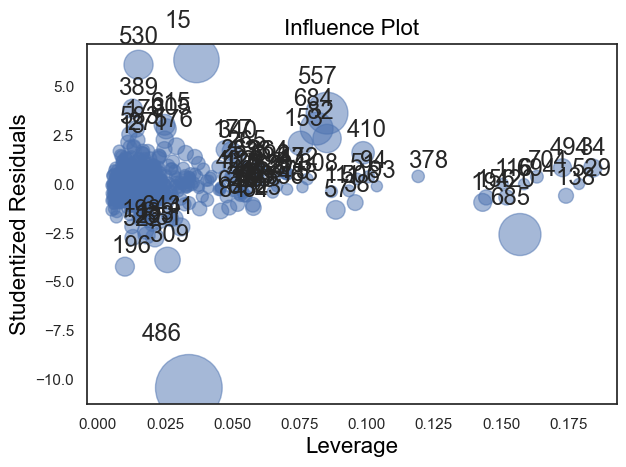

In [1966]:
fig = sm.graphics.influence_plot(
    combined_model,
    criterion="cooks",
    plot_alpha=0.5,
    )
fig.tight_layout(pad=1.0)


In [1967]:
games_returns_release_df.iloc[[486, 487, 530]]

,name,mature,single_player,multiplayer,dist,hasLootBoxes,percentRecommended,numReviews,numTopCriticReviews,medianScore,...,numMedianScore,numTopCriticScore,de_mean_score,std_score,log_excess_ret,region,dev_pub,age_rating,players,LogsizeTopCriticScore
580,Indivisible,0,1,1,0.0,0,72.340426,96.0,70.0,80.0,...,5478.805970,5478.805970,5.911842,0.540535,-0.010761,eu,publisher,other,Multiplayer,1462.858677
581,Detroit: Become Human,1,1,0,0.0,0,70.833333,152.0,113.0,80.0,...,8886.407767,8886.407767,6.283962,0.574558,0.030161,jp,publisher,mature,Single Player,1950.689902
631,New Gundam Breaker,0,1,1,0.0,0,0.000000,26.0,23.0,46.5,...,963.000000,963.000000,-30.487249,-2.787526,0.022259,jp,publisher,other,Multiplayer,962.314071


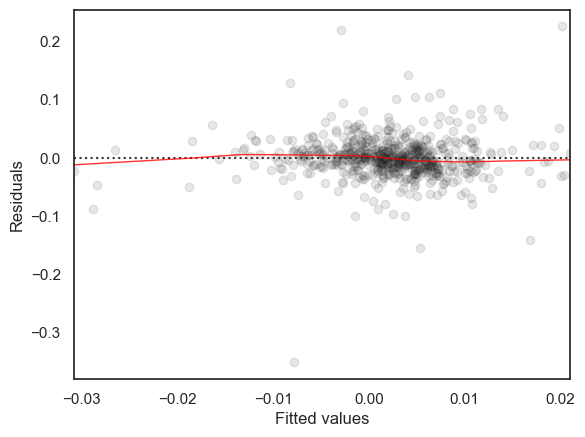

In [1968]:
# fitted values
model_fitted_y = combined_model.fittedvalues

#  Plot
fig, ax = plt.subplots()
sns.residplot(x=model_fitted_y, y='log_excess_ret', data=games_returns_release_df, lowess=True, 
                     scatter_kws={'alpha': 0.1}, 
                     line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
                     ax=ax,
                     color='k'
                     )

# Titel and labels
ax.set_xlabel('Fitted values')
ax.set_ylabel('Residuals')
fig.savefig('combined_model_residuals_plot.png')

In [1969]:
#perform White's test
white_test = het_white(combined_model.resid,  combined_model.model.exog)

#define labels to use for output of White's test
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

#print results of White's test
print(dict(zip(labels, white_test)))

{'Test Statistic': 170.26836097875218, 'Test Statistic p-value': 1.3159119413555565e-06, 'F-Statistic': 2.1774360998929825, 'F-Test p-value': 4.9010455323787446e-08}


In [1970]:
# Test for auto-correlation.
durbin_watson(combined_model.resid) 

2.1015522982204127

In [1971]:
np.exp(0.0669) -1 

0.06918855397308188

In [1972]:
0.0044*80 - 0.0002*(19*80) + 0.0147*19

0.32730000000000004

Calculate AIC for the three models.

In [1973]:
0.00002 * 39

0.0007800000000000001

In [1974]:
0.00226*(73.46) + 0.00723*(22.15) - 0.0001*(22.15*73.46) -0.15652

0.0069301999999999975